# Getting started
___
The following illustrates the basic functionalities of the proteusAI package, such as training machine learning models using experimental data, performing zero-shot predictions and visualizing results. 

## Training models with experimental data
___

### 1.  Loading data from csv files

In [1]:
import sys
sys.path.append('../src/')
import proteusAI as pai

# will initiate storage space - else in memory
library = pai.Library(project='example_project', overwrite=False) 

# load data from csv or excel: x should be sequences, y should be labels, y_type class or num
library.read_data(data='demo_data/GB1_raw.csv', seqs='Sequence', y='Data', y_type='num', names='Description')

# compute and save ESM-2 representations at example_lib/representations/esm2
library.compute(method='esm2')

Library example_project already exists. Loading existing library...
Initializing library 'example_project'...
Done!
Loading library 'example_project'...
- Found representations of type 'esm2' in 'rep/esm2'.
- Found representations of type 'ohe' in 'rep/ohe'.
- Found representations of type 'blosum62' in 'rep/blosum62'.
- Found representations of type 'blosum50' in 'rep/blosum50'.
Loading done!


FileNotFoundError: [Errno 2] No such file or directory: 'demo_data/GB1_raw.csv'

### 2. Training models

In [2]:
# Choose model type, random forest, linear regression, svm, ...
model = pai.Model(model_type='knn')

# will save a model and report at models/rf/
model.train(library=library, x='esm2', split='random')

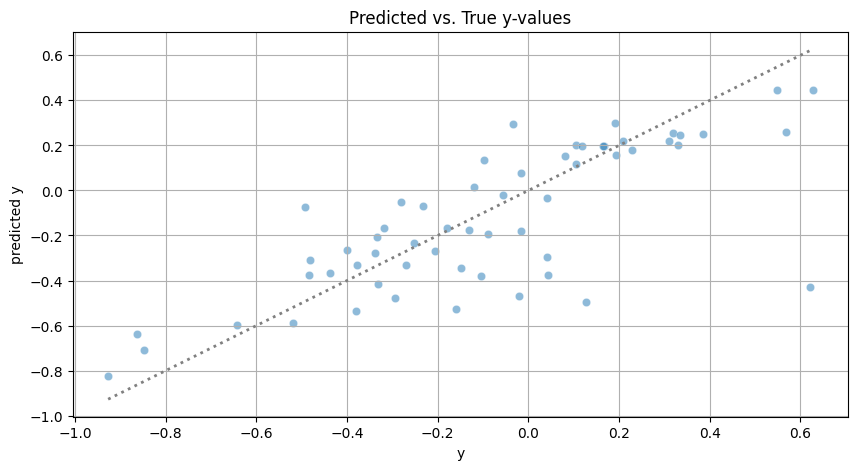

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Predicted vs. True y-values'}, xlabel='y', ylabel='predicted y'>)

In [3]:
y_t = model.y_val
y_p = model.y_val_pred
model.true_vs_predicted(y_t, y_p, file='val_predicted_vs_true.png')

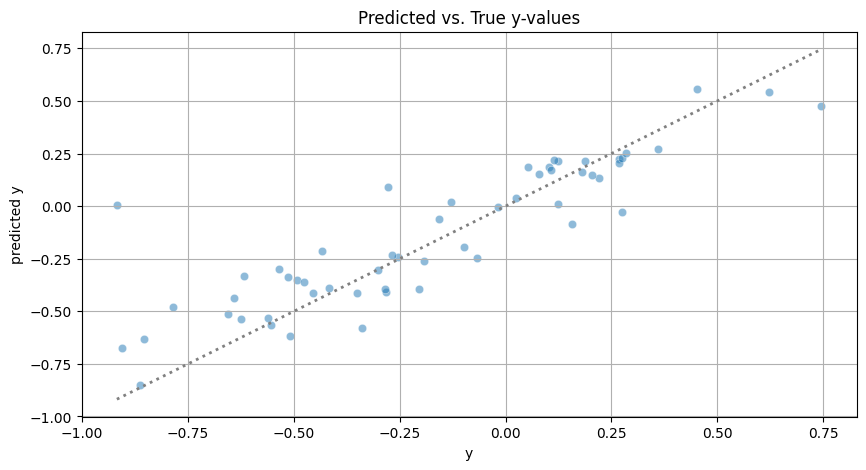

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Predicted vs. True y-values'}, xlabel='y', ylabel='predicted y'>)

In [4]:
y_t = model.y_test
y_p = model.y_test_pred
model.true_vs_predicted(y_t, y_p)

### 3. Creating model ensembles

In [5]:
#ensemble = pai.Ensemble([model_1, model_2])

### 4. Loading existing libraries and models

In [6]:
# load a library object
#library = pai.Library.load(data='path/to/library')

# load a model object
#model = pai.Model.load(data='path/to/model')

### 5. Making predictions

In [7]:
# load a library object
#library = pai.Library.load(data='path/to/library')

# load a model object
#model = pai.Model.load(data='path/to/model')

### Visualizing library and model results

In [8]:
# create tSNE plot of esm2 representations, colored by class
#library.tsne(x='esm2', fname='path/to/plot/tSNE.png', show=True)

## Making zero-shot predictions
___
### 1. Creating a protein object

In [1]:
import sys
sys.path.append('../src/')
import proteusAI as pai

# loading a protein from a fasta file
protein = pai.Protein.load_fasta('demo_data/GB1_wt.fasta')
protein

proteusAI.Protein():
____________________
name	: wt|GB1
seq	: MAPTLSEQTRQLVRASVPALQKHSVAISATMYRLLFERYPETRSLCELPERQIHKIASALLAYARSIDNPSALQAAIRRMVLSHARAGVQAVHYPLYWECLRDAIKEVLGPDATETLLQAWKEAYDFLAHLLSTKEAQVYAVLAE
rep	: []
y	None

In [2]:
protein.path = 'example_project/'
protein.path

'example_project/'

### 2. Create a library

In [3]:
# create a deep-mutational scanning library
#library = protein.DMS(name='dms')
#library

### Compute scores

In [4]:
# create zero-shot scores using the ESM-2 model and the masked-marginal probability metric
protein.zs_prediction(model='esm2')
#library

computing logits
example_project/


In [4]:
import torch
from proteusAI.ml_tools.esm_tools import *

logit = torch.load("example_project/zero_shot/esm2/3b7918a68678eae7f05e55ddc6ac7971/masked_logits.pt")
p = torch.load("example_project/zero_shot/esm2/3b7918a68678eae7f05e55ddc6ac7971/prob_dist.pt")
mmp = torch.load("example_project/zero_shot/esm2/3b7918a68678eae7f05e55ddc6ac7971/masked_marginal_probability.pt")
entropy = torch.load("example_project/zero_shot/esm2/3b7918a68678eae7f05e55ddc6ac7971/per_position_entropy.pt")


In [49]:
import pandas as pd

def zs_to_csv(wt_seq: str, alphabet: esm.data.Alphabet, p: torch.Tensor, mmp: torch.Tensor, entropy: torch.Tensor, dest: str):
    """
    Save the results as a CSV file.

    Args:
        wt_seq (str): Wildtype sequence.
        alphabet (esm.data.Alphabet): Alphabet used for the model.
        p (torch.Tensor): Probability distribution tensor.
        mmp (torch.Tensor): Masked marginal probability tensor.
        entropy (torch.Tensor): Per-position entropy tensor.
        dest (str): Destination path for the CSV file.
    """
    # Convert alphabet to list for indexing
    alphabet_list = list(alphabet.to_dict().keys())
    alphabet = alphabet.to_dict()
    canonical_aas = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

    with open(dest, 'w', newline='') as csvfile:
        fieldnames = ['mutant', 'p', 'mmp', 'entropy']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        #writer.writeheader()
        mutants, p_values, mmp_values, entropy_values = [], [], [], []
        for pos in range(len(wt_seq)):
            for aa in canonical_aas:
                if wt_seq[pos] != aa:
                    mutants.append(wt_seq[pos] + str(pos+1) + aa)
                    p_values.append(p[0, pos, alphabet[aa]].item())
                    mmp_values.append(mmp[0, pos, alphabet[aa]].item())
                    entropy_values.append(entropy[0, pos].item())
    
        df = pd.DataFrame({
            'mutant': mutants,
            'p': p_values,
            'mmp': mmp_values,
            'entropy': entropy_values
        })
        df.to_csv(dest, index=False)

# Example usage
# Assuming you have the required tensors and alphabet from previous computations
zs_to_csv(protein.seq, alphabet, p, mmp, entropy, 'example_project/zero_shot/esm2/zs_scores.csv')

In [13]:
# inspect results
#scores = library.zs_scores()
#scores

## Training VAEs
___
### 1. loading MSA

In [14]:
# different formats can be provided 
#msa = pai.Library.load_msa(name='msa', data='msa.fasta')
#msa

### 2. Training a VAE

In [15]:
#vae = pai.Model(type='vae', layers=[2000, 1000, 500], z_dim=200)
#vae = vae.train(lib=msa)

### 3. Use the VAE to create representations

In [16]:
#msa.compute(method='vae', model=vae)

### 4. Finetune VAE

In [17]:
# load library with experimental data
#library = pai.Library.load(data='path/to/library')

# fine tune VAE
#model = pai.Model(lib=library, fine_tune=vae)